<a href="https://colab.research.google.com/github/AzusaFighting/DVdata/blob/main/lab8_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.autonotebook import tqdm
from itertools import chain

import numpy as np

from google.colab import files

batch_size = 256
# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


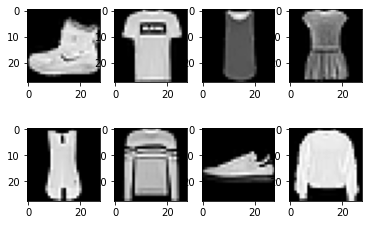

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

for i in range(8):
    plt.subplot(int(str(24)+str(i+1)))
    plt.imshow(train_set.train_data[i], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

In [64]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    '''
    simple encoder with no hidden dense layer
    '''
    def __init__(self, image_dim, enc_hidden_units, embedding_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(image_dim, enc_hidden_units)
        self.mu = nn.Linear(enc_hidden_units, embedding_dim)
        self.sigma = nn.Linear(enc_hidden_units, embedding_dim)

    def forward(self, x):
        x = F.relu(self.fc(x))
        return self.mu(x), self.sigma(x)


class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, embedding_dim, dec_hidden_units, image_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, dec_hidden_units)
        self.fc2 = nn.Linear(dec_hidden_units, image_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

  0%|          | 0/235 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


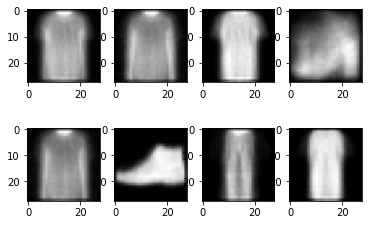

  0%|          | 0/235 [00:00<?, ?it/s]

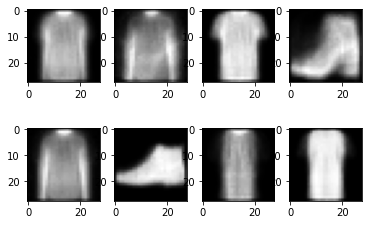

  0%|          | 0/235 [00:00<?, ?it/s]

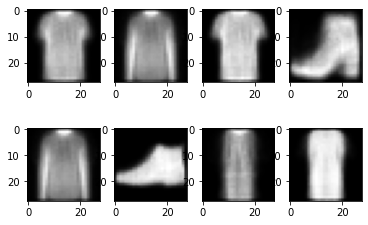

  0%|          | 0/235 [00:00<?, ?it/s]

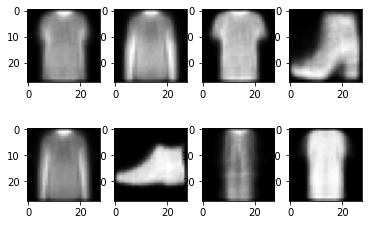

  0%|          | 0/235 [00:00<?, ?it/s]

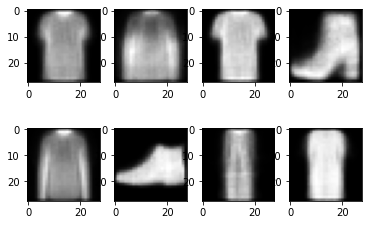

In [65]:
import matplotlib.gridspec as gridspec    
import os
import matplotlib.pyplot as plt

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])
    return mu + torch.exp(log_sigma2 / 2) * eps


#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 5
image_dim = 784 #flattened
# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        
        kl = 0 
        # Compute the term kl which is then added to the total loss
        kl = 0.5 * torch.sum(mu.pow(2) + log_sigma2.exp() - log_sigma2 -1)
        kl /= inputs.shape[0]
        
        loss = recon + kl
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
        
    for i, data in enumerate(trainloader):
        inputs,_ = data
        mu, log_sig = enc(inputs)
        z = sample(mu, log_sig)
        outputs = dec(z)

    for i in range(8):
        plt.subplot(int(str(24) + str(i + 1)))
        plt.imshow(outputs[i].data.reshape(28, 28), cmap=plt.get_cmap('gray'))

    plt.show()

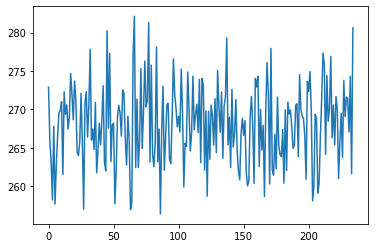

In [69]:
plt.plot(losses)

20 20 tensor([[ 4., -4.]])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

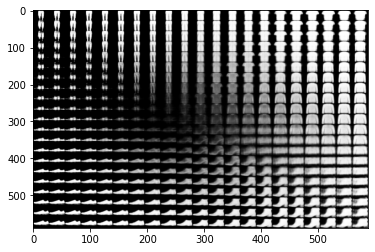

In [68]:
from google.colab import files

## Random images generated from prior sampling
w, h = 28, 28
cnt = 21
sample_img = torch.zeros((h * cnt, w * cnt)) # HW
for xi, x_prior in enumerate(torch.linspace(-4, 4, cnt)):
  for yi, y_prior in enumerate(torch.linspace(4, -4, cnt)):
    z = torch.tensor((x_prior, y_prior)).unsqueeze(0)
    output = dec(z)
    if(xi == 20 and yi == 20):
      print(xi, yi, z)
    output = output.detach().reshape(28,28)
    sample_img[yi*h:yi*h+h, xi*w:xi*w+w] = output

filename = "VAE_sample.png"
torchvision.utils.save_image(sample_img, filename)
plt.imshow(sample_img, cmap=plt.get_cmap('gray'),aspect='auto')
files.download(filename)

In [70]:
# import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    '''
    simple encoder with no hidden dense layer
    '''
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        out = self.fc(x)
        return out

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.fc(x)
        out = torch.sigmoid(out)
        return out

  0%|          | 0/235 [00:00<?, ?it/s]

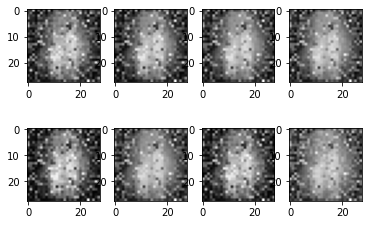

  0%|          | 0/235 [00:00<?, ?it/s]

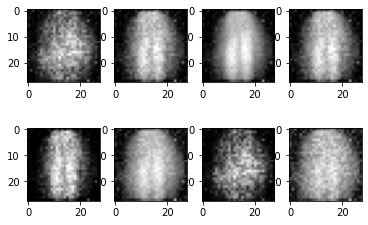

  0%|          | 0/235 [00:00<?, ?it/s]

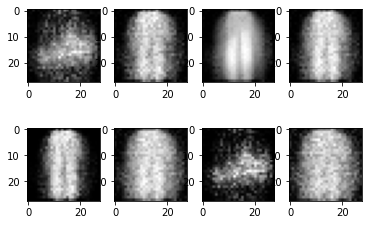

  0%|          | 0/235 [00:00<?, ?it/s]

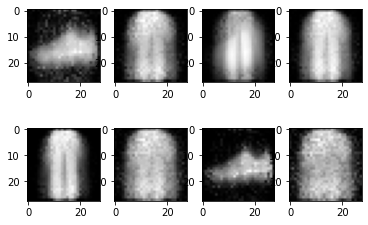

  0%|          | 0/235 [00:00<?, ?it/s]

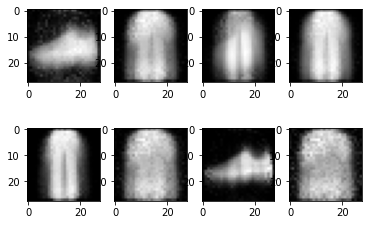

  0%|          | 0/235 [00:00<?, ?it/s]

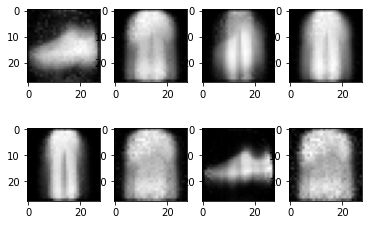

  0%|          | 0/235 [00:00<?, ?it/s]

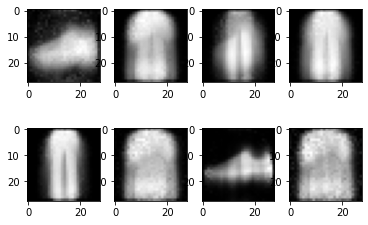

  0%|          | 0/235 [00:00<?, ?it/s]

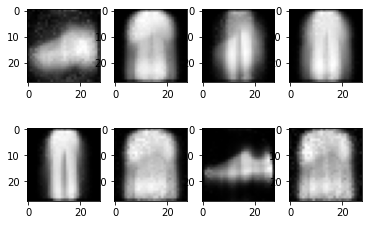

  0%|          | 0/235 [00:00<?, ?it/s]

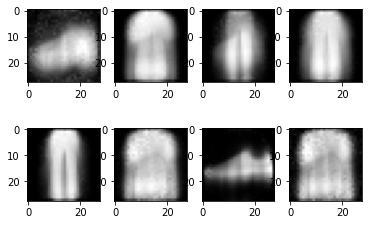

  0%|          | 0/235 [00:00<?, ?it/s]

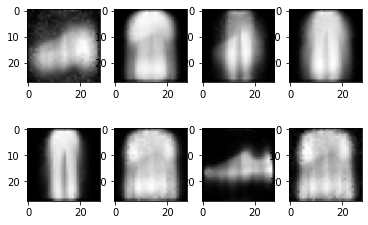

In [71]:
import matplotlib.gridspec as gridspec    
import os
import torch.optim as optim
import numpy as np

from tqdm.autonotebook import tqdm
from itertools import chain

# enc_dim = 64
enc_dim = 2 #for lab8
image_dim = 784  # [flattened]
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_dim)
dec = Decoder(enc_dim, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        z = enc(inputs)
        outputs = dec(z)

        loss = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
    
    
    for i, data in enumerate(trainloader):
        inputs,_ = data
        z = enc(inputs)
        outputs = dec(z)
        break

    for i in range(8):
        plt.subplot(int(str(24) + str(i + 1)))
        plt.imshow(outputs[i].data.reshape(28, 28), cmap=plt.get_cmap('gray'))

    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

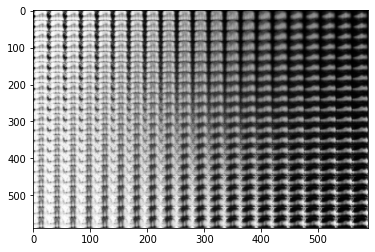

In [72]:
from google.colab import files

## Random images generated from prior sampling
w, h = 28, 28
cnt = 21
sample_img = torch.zeros((h * cnt, w * cnt)) # HW
for xi, x_prior in enumerate(torch.linspace(-4, 4, cnt)):
  for yi, y_prior in enumerate(torch.linspace(4, -4, cnt)):
    z = torch.tensor((x_prior, y_prior)).unsqueeze(0)
    output = dec(z)
    output = output.detach().reshape(28,28)
    sample_img[yi*h:yi*h+h, xi*w:xi*w+w] = output

filename = "auto_sample.png"
torchvision.utils.save_image(sample_img, filename)
plt.imshow(sample_img, cmap=plt.get_cmap('gray'),aspect='auto')
files.download(filename)